# Experimento 1
***
- Conjuntos de dados: Montgomery + Shenzen
- Testando a equalização de histograma em comparação com a mudança típica de escala

### Importando os pacotes necessários

In [1]:
import glob
import re
from tqdm import tqdm
import urllib.request
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

### Pré-processando os dados

In [5]:
# coletando o caminho dos arquivos dos dados do hospital shenzen
filelist_shenzen = glob.glob('/content/drive/MyDrive/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/*.png')
# coletando o caminho dos arquivos dos dados do hospital montgomery
filelist_montgomery = glob.glob('/content/drive/MyDrive/Montgomery/MontgomerySet/CXR_png/*.png')
# juntando os dois datasets
filelist = filelist_shenzen + filelist_montgomery

In [6]:
# quantidade de imagens disponíveis no dataset
print('quantidade de imagens:', str(len(filelist)))

quantidade de imagens: 800


In [7]:
def extract_label(file_list):
    
    # inicializando uma lista vazia
    labels = []
    
    # iterando na lista de arquivos
    for file in tqdm(file_list):
        # detectando as classes presentes no nome da imagem
        current_label = re.findall('[0-9]{4}_(.+?).png', file)
        # adicionando a lista de rótulos as classes correspondentes a cada uma das imagens
        if current_label[0] == '0':
          labels.append('normal')
        else:
          labels.append('abnormal')
        
    return labels

In [8]:
# extraindo os rótulos
labels = extract_label(filelist)

100%|██████████| 800/800 [00:00<00:00, 188911.34it/s]


In [9]:
# visualizando a quantidade de rótulos
print('quantidade de rótulos:', str(len(labels)))

quantidade de rótulos: 800


In [10]:
# criando um dataframe com os caminhos das imagens
full_data = pd.DataFrame(filelist, columns = ['filepath'])
# adicionando os rótulos em cada imagem
full_data['target'] = labels

In [12]:
# separando os dados de treinamento e de teste
train_df, test_df = train_test_split(full_data, stratify = full_data['target'],
                                     test_size = 0.2, random_state = 42)

In [13]:
# separando os dados de validação dos dados de treinamento
train_df, validation_df = train_test_split(train_df, stratify = train_df['target'],
                                           test_size = 0.2, random_state = 42)

In [14]:
# visualizando a quantidade de dados
print('quantidade de imagens de treinamento:', len(train_df['filepath']))
print('quantidade de rótulos de treinamento:', len(train_df['target']))
print('quantidade de imagens de teste:', len(test_df['filepath']))
print('quantidade de rótulos de teste:', len(test_df['target']))
print('quantidade de imagens de validação:', len(validation_df['filepath']))
print('quantidade de rótulos de validação:', len(validation_df['target']))

quantidade de imagens de treinamento: 512
quantidade de rótulos de treinamento: 512
quantidade de imagens de teste: 160
quantidade de rótulos de teste: 160
quantidade de imagens de validação: 128
quantidade de rótulos de validação: 128


In [25]:
# observando a distribuição na quantidade de dados disponíveis
print(train_df['target'].value_counts())
# fazendo um balanceamento nos pesos das classes
class_weight = {0: (260+252)/252, 1: (214+209)/260}

normal      260
abnormal    252
Name: target, dtype: int64


### Aplicando mudança de escala típica

In [15]:
# normalizando as imagens de treinamento e aplicando aumento de dados
image_generator = ImageDataGenerator(rescale = 1./255., rotation_range = 10, zoom_range = 0.2)

# criando o gerador de imagens de treinamento 
train_generator = image_generator.flow_from_dataframe(
                                                      dataframe = train_df,
                                                      directory = '',
                                                      x_col = 'filepath',
                                                      y_col = 'target',
                                                      batch_size = 32,
                                                      seed = 42,
                                                      shuffle = True,
                                                      class_mode = 'categorical',
                                                      target_size = (256, 256))

# normalizando as imagens de teste e validação
test_datagen = ImageDataGenerator(rescale = 1./255.)

# criando o gerador de imagens de validação 
valid_generator = test_datagen.flow_from_dataframe(
                                                      dataframe = validation_df,
                                                      directory = '.', 
                                                      x_col = 'filepath',
                                                      y_col = 'target',
                                                      batch_size = 32,
                                                      seed = 42,
                                                      shuffle = True,
                                                      class_mode = 'categorical',
                                                      target_size = (256, 256))

test_generator = test_datagen.flow_from_dataframe(
                                                  dataframe = test_df, 
                                                  directory = '.',
                                                  x_col = 'filepath',
                                                  y_col = 'target',
                                                  batch_size = 32,
                                                  seed = 42,
                                                  shuffle = True,
                                                  class_mode = 'categorical',
                                                  target_size = (256, 256))

Found 512 validated image filenames belonging to 2 classes.
Found 128 validated image filenames belonging to 2 classes.
Found 160 validated image filenames belonging to 2 classes.


In [23]:
train_generator.class_indices

{'abnormal': 0, 'normal': 1}

### Preparando a rede neural convolucional

In [16]:
# baixando os pesos treinados da rede inception
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-04-15 12:53:35--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.197.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  90.2MB/s    in 0.9s    

2021-04-15 12:53:36 (90.2 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [17]:
# referenciando o local em que os pesos estão armazenados
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# carregando a arquitetura inception pré-treinada
pre_trained_model = InceptionV3(input_shape = (256, 256, 3), 
                                include_top = False, 
                                weights = None)

# carregando os pesos treinados com outros dados 
pre_trained_model.load_weights(local_weights_file)

# obtendo a última camada como sendo a nomeada por 'mixed7'
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

In [18]:
x = layers.GlobalAveragePooling2D()(last_output)
# adicionando uma camada densa com 512 neurônios
x = layers.Dense(units = 512, activation = tf.nn.relu)(x)     
# conecatando a rede uma camada com 128 neurônios e função de ativação relu
x = layers.Dense(units = 256, activation = tf.nn.relu)(x) 
# aplicando uma camada de dropout com uma taxa de 20% (normalização)
x = layers.Dropout(rate = 0.2)(x)      
# adicionando uma camada de saída com um neurônio e uma função de ativação sigmoide
x = layers.Dense  (units = 2, activation = tf.nn.softmax)(x)            

# conecatando as camadas definidas acima com a arquitetura inception
model = Model(pre_trained_model.input, x) 

# compilando a rede 
model.compile(optimizer = optimizers.RMSprop(learning_rate = 0.0001), loss = 'categorical_crossentropy', 
              metrics = ['acc']) 

In [19]:
# definindo as flags iniciais  
pre_trained_model.trainable = True
set_trainable = False

# para a arquitetura inception, a rede será retreinada a partir da camada 'mixed6'
for layer in pre_trained_model.layers:
    if layer.name == 'mixed6':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [20]:
# definindo o caminho pelo qual os pesos serão armazenados 
filepath = "transferlearning_weights.hdf5"
# callback para salvar o melhor valor dos pesos em relação ao desempenho com os dados de validação 
checkpoint = ModelCheckpoint(filepath, monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')

In [21]:
# definindo um array de callbacks
callbacks = [checkpoint]

In [27]:
# treinando a rede neural convolucional
history = model.fit_generator(train_generator, steps_per_epoch = 512  // 32, 
                              validation_data = valid_generator, validation_steps = 128 // 32,
                              callbacks = callbacks, epochs = 100, class_weight = class_weight,
                              use_multiprocessing = True, workers = 8)

Epoch 1/100
16/16 [==============================] - 201s 8s/step - loss: 1.1643 - acc: 0.5912 - val_loss: 0.6335 - val_acc: 0.6016

Epoch 00001: val_acc improved from -inf to 0.60156, saving model to transferlearning_weights.hdf5
Epoch 2/100
16/16 [==============================] - 52s 2s/step - loss: 0.7832 - acc: 0.8332 - val_loss: 0.9456 - val_acc: 0.5469

Epoch 00002: val_acc did not improve from 0.60156
Epoch 3/100
16/16 [==============================] - 57s 3s/step - loss: 0.5729 - acc: 0.8911 - val_loss: 1.7865 - val_acc: 0.5312

Epoch 00003: val_acc did not improve from 0.60156
Epoch 4/100
16/16 [==============================] - 57s 2s/step - loss: 0.4842 - acc: 0.8748 - val_loss: 1.9347 - val_acc: 0.5859

Epoch 00004: val_acc did not improve from 0.60156
Epoch 5/100
16/16 [==============================] - 56s 3s/step - loss: 0.3212 - acc: 0.9154 - val_loss: 3.5557 - val_acc: 0.5391

Epoch 00005: val_acc did not improve from 0.60156
Epoch 6/100
16/16 [======================

### Salvando o modelo desenvolvido

In [28]:
# carregando o melhor peso obtido para o modelo
best_model = model
best_model.load_weights('/content/transferlearning_weights.hdf5')

In [29]:
# salvando os dois modelos obtidos durante o treinamento
model.save('model1')
best_model.save('model2')

INFO:tensorflow:Assets written to: model1/assets
INFO:tensorflow:Assets written to: model2/assets


In [31]:
# carregando o melhor modelo para realização de testes de desempenho
model = tf.keras.models.load_model('/content/drive/MyDrive/experimentos/v2.0-exp1-ds3/model2')

### Métricas de avaliação do modelo

In [35]:
# analisando a capacidade de predição do modelo com os dados de teste
model.evaluate(test_generator)

5/5 [==============================] - 22s 4s/step - loss: 0.7252 - acc: 0.8687


[0.7251859307289124, 0.8687499761581421]

In [32]:
# carregando os dados de teste 
(x1, y1) = test_generator[0]
(x2, y2) = test_generator[1]
(x3, y3) = test_generator[2]
(x4, y4) = test_generator[3]
(x5, y5) = test_generator[4]

x = np.concatenate((x1, x2, x3, x4, x5))
y = np.concatenate((y1, y2, y3, y4, y5))

In [33]:
# realizando a predição para os dados de teste
predict = model.predict(x)

In [34]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix

def thresholds(limiar, predict):
  '''predição para diferentes thresholds'''

  predict_ = []
  for i in predict:
    if i > limiar:
      predict_.append(1)
    else:
      predict_.append(0)
  
  return predict_

def precision_recall_accuracy_curve(predict, y):
  ''' Relaciona a curva da Precisão, Sensibilidade e Acurácia em relação a diferentes Thresholds'''

  limiares = np.arange(0, 1, 0.05)
  predicts = []
  precisions = []
  recalls = []
  accuracy = []
  flag = 0
  for i in limiares:
    predicts.append(thresholds(i, predict))
    precisions.append(precision_score(predicts[flag], y))
    recalls.append(recall_score(predicts[flag], y))
    accuracy.append(accuracy_score(predicts[flag], y))
    flag += 1
  
  return precisions, recalls, accuracy

def plot_precision_recall_accuracy_curve(precisions, recalls, accuracy):
  '''Plotando a curva de Precisão, Sensibilidade e Acurácia'''

  plt.figure(figsize = (10,5))
  plt.plot(np.arange(0, 1, 0.05), precisions, label = 'Precision')
  plt.plot(np.arange(0, 1, 0.05), recalls, label = 'Recall')
  plt.plot(np.arange(0, 1, 0.05), accuracy, label = 'Accuracy')
  plt.title('Precisão, Sensibilidade e Acurácia para diferentes Thresholds')
  plt.xlabel('Thresholds')
  plt.legend()
  plt.savefig('curve-analysis')

  return None

def best_metrics(threshold, predict, y):
  '''Melhores valores para o threshold escolhido'''

  predict_ = thresholds(threshold, predict)
  print('Matriz de Confusão:\n', confusion_matrix(predict_, y))
  print('Acurácia:', accuracy_score(predict_, y))
  print('Precisão', precision_score(predict_, y))
  print('Sensibilidade:', recall_score(predict_, y)) 
  print('F1_Score:', f1_score(predict_, y))

  return None

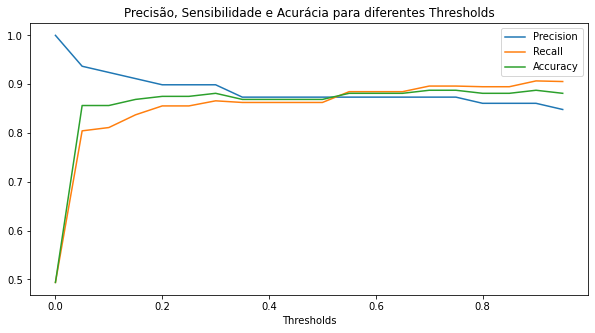

In [36]:
# plotando a curva da Precisão, Sensibilidade e Acurácia 
precisions, recalls, accuracy = precision_recall_accuracy_curve(predict[:,0], y[:,0])
plot_precision_recall_accuracy_curve(precisions, recalls, accuracy)

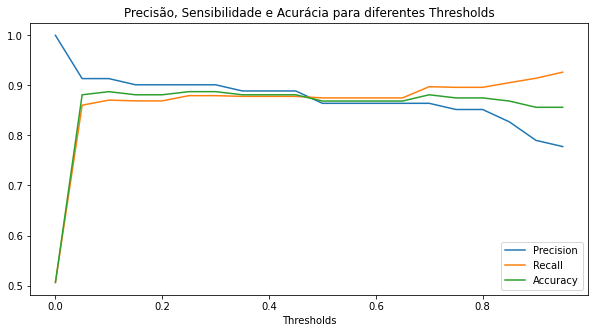

In [37]:
# plotando a curva da Precisão, Sensibilidade e Acurácia 
precisions, recalls, accuracy = precision_recall_accuracy_curve(predict[:,1], y[:,1])
plot_precision_recall_accuracy_curve(precisions, recalls, accuracy)

In [39]:
# analisando as melhores métricas encontradas para o modelo
best_metrics(threshold = 0.70, predict = predict[:,0], y = y[:,0])

Matriz de Confusão:
 [[73 10]
 [ 8 69]]
Acurácia: 0.8875
Precisão 0.8734177215189873
Sensibilidade: 0.8961038961038961
F1_Score: 0.8846153846153846


In [40]:
# analisando as melhores métricas encontradas para o modelo
best_metrics(threshold = 0.70, predict = predict[:,1], y = y[:,1])

Matriz de Confusão:
 [[71 11]
 [ 8 70]]
Acurácia: 0.88125
Precisão 0.8641975308641975
Sensibilidade: 0.8974358974358975
F1_Score: 0.880503144654088


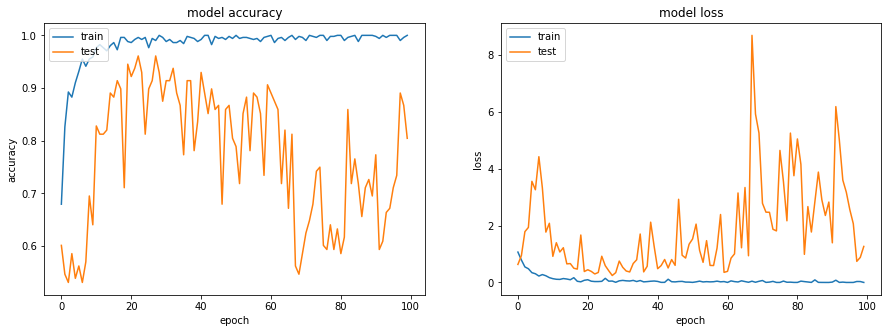

In [41]:
# visualizando o ganho de acurácia durante o treinamento
plt.figure(figsize = (15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model-accuracy')

# visualizando o decaimento da função de custo durante o treinamento 
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model-loss')

### Algoritmo Grad Cam

In [43]:
import urllib.request as url

link = 'https://raw.githubusercontent.com/Alyssonmach/class-activation-maps/main/assets/grad_cam.py'
file_ = 'grad_cam.py'
url.urlretrieve(link, file_)

from grad_cam import get_img_array, make_gradcam_heatmap, save_and_display_gradcam

In [44]:
# tamanho padrão das imagens do modelo
img_size = (256, 256)
# importando os parâmetros de pré-processamento da rede
preprocess_input = tf.keras.applications.inception_v3.preprocess_input
# definindo a última camada da rede a ser considerada
last_conv_layer = 'mixed7'
model_builder = model
# removendo a função de ativação da última camada
model_builder.layers[-1].activation = None

Classe prevista: [1. 0.]


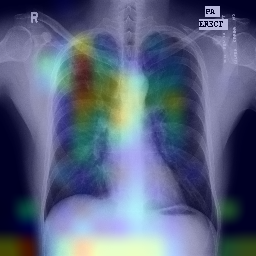

In [83]:
img, lbl = x[1], y[1]

img_path = tf.keras.preprocessing.image.array_to_img(img)

# preparando a imagem
img_array = preprocess_input(get_img_array(img_path, img_size))

# obtendo a predição do modelo
preds = model_builder.predict(img_array)
print('Classe prevista: {}'.format(lbl))

# gerando o mapa de ativação de classe (Grad-Cam)
heatmap = make_gradcam_heatmap(img_array, model_builder, last_conv_layer,
                               pred_index = 0)

# resultado final do algoritmo Grad-Cam
heatmap = save_and_display_gradcam(img_path, heatmap, cam_path = 'image1.png')

Classe prevista: [1. 0.]


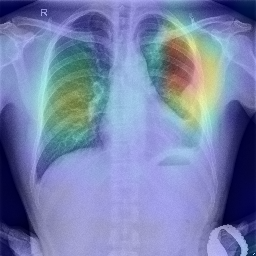

In [84]:
img, lbl = x[4], y[4]

img_path = tf.keras.preprocessing.image.array_to_img(img)

# preparando a imagem
img_array = preprocess_input(get_img_array(img_path, img_size))

# obtendo a predição do modelo
preds = model_builder.predict(img_array)
print('Classe prevista: {}'.format(lbl))

# gerando o mapa de ativação de classe (Grad-Cam)
heatmap = make_gradcam_heatmap(img_array, model_builder, last_conv_layer,
                               pred_index = 0)

# resultado final do algoritmo Grad-Cam
heatmap = save_and_display_gradcam(img_path, heatmap, cam_path = 'image2.png')

Classe prevista: [1. 0.]


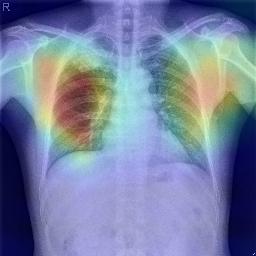

In [85]:
img, lbl = x[133], y[133]

img_path = tf.keras.preprocessing.image.array_to_img(img)

# preparando a imagem
img_array = preprocess_input(get_img_array(img_path, img_size))

# obtendo a predição do modelo
preds = model_builder.predict(img_array)
print('Classe prevista: {}'.format(lbl))

# gerando o mapa de ativação de classe (Grad-Cam)
heatmap = make_gradcam_heatmap(img_array, model_builder, last_conv_layer,
                               pred_index = 0)

# resultado final do algoritmo Grad-Cam
heatmap = save_and_display_gradcam(img_path, heatmap, cam_path = 'image3.png')

Classe prevista: [1. 0.]


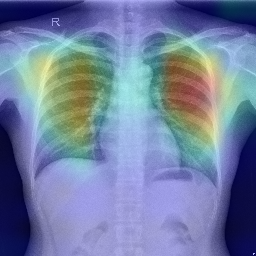

In [86]:
img, lbl = x[45], y[45]

img_path = tf.keras.preprocessing.image.array_to_img(img)

# preparando a imagem
img_array = preprocess_input(get_img_array(img_path, img_size))

# obtendo a predição do modelo
preds = model_builder.predict(img_array)
print('Classe prevista: {}'.format(lbl))

# gerando o mapa de ativação de classe (Grad-Cam)
heatmap = make_gradcam_heatmap(img_array, model_builder, last_conv_layer,
                               pred_index = 0)

# resultado final do algoritmo Grad-Cam
heatmap = save_and_display_gradcam(img_path, heatmap, cam_path = 'image4.png')

### Arquitetura do modelo

In [42]:
# visualizando a arquitetura do modelo
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________